In [2]:
import ismrmrd
import rtoml
import os
import fnmatch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)


In [3]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0902_20240611/raw/h5/meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4427 waveforms in the dataset. Reading...


In [4]:
mri_coils = np.arange(15, dtype=int)
sensing_coils = np.array([15, 16, 17], dtype=int)
coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

ksp_measured = data[:,:,mri_coils]
ksp_sniffer  = data[:,:,sensing_coils]



Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


In [62]:
import numpy.typing as npt
import math
import scipy as sp

def get_noise_mtx(line_grp: npt.NDArray[np.complex64], dk: list[int]):
    """
    Creates the shifted noise matrix for a given line group and kernel sizes.

    Args:
        line_grp (numpy.ndarray): Line group data of shape (Nsamples, Nlines, Nchannels).
        dk (list or tuple): Kernel size [d_kx, d_ky].

    Returns:
        numpy.ndarray: Noise matrix of shape ((Nsamples * Nlines) x (Nchannels * (d_kx * 2 + 1) * (d_ky * 2 + 1))).
    """
    d_kx = dk[0]
    d_ky = dk[1]

    noise_mat = []
    dfp = np.pad(line_grp, ((d_kx, d_kx), (d_ky, d_ky), (0, 0)), mode='constant')
    if d_ky == 0:
        end_slc = None
    else:
        end_slc = d_ky
    for col_shift in range(-d_kx, d_kx + 1):
        for lin_shift in range(-d_ky, d_ky + 1):
            dftmp = np.roll(dfp, shift=(col_shift, lin_shift), axis=(0, 1))
            cropped = dftmp[d_kx:-d_kx, d_ky:end_slc, :]
            noise_mat.append(cropped)

    noise_mat = np.concatenate(noise_mat, axis=2)
    noise_mat = noise_mat.reshape(noise_mat.shape[0] * noise_mat.shape[1], -1)

    return noise_mat

def est_emi(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):

    Ncol, Nlin, Nc = sniffer.shape
    Ngrp = len(line_grps)
    emi_hat = np.zeros((Ncol, Nlin), dtype=np.complex64)
    kern = [] # np.zeros((Nc * (dk[0] * 2 + 1) * (dk[1] * 2 + 1), Ngrp))

    for cwin, pe_rng in enumerate(line_grps):
        # pe_rng is the range of lines in the current group
        noise_mat = get_noise_mtx(sniffer[:, pe_rng, :], dk)

        # Select grouped lines and flatten for inversion
        init_mat_sub = np.reshape(signal_in[:, pe_rng], (Ncol * len(pe_rng), 1))
        ww = np.reshape(w[:, pe_rng], (Ncol * len(pe_rng), 1))
        
        # Solving the linear system
        kern_ ,_,_,_ = sp.linalg.lstsq(ww * noise_mat, ww * init_mat_sub, cond=None, check_finite=False)
        kern.append(kern_)
        # Put the solution back
        emi_hat[:, pe_rng] = np.reshape(np.dot(noise_mat, kern_), (Ncol, len(pe_rng)))

    return emi_hat

def apply_editer(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], params, w) -> tuple[npt.NDArray[np.complex64], npt.NDArray[np.complex64]]:
    max_lines = params['max_lines_per_group']
    nlin = signal_in.shape[1]
    if params['grouping_method'] == "uniform":
        Ngrp = math.ceil(nlin/max_lines)
        line_grps = []

        for grp_i in range(Ngrp):
            line_grps.append(np.arange(((grp_i)*max_lines), min(max_lines*(grp_i+1), nlin)))


    emi_hat = est_emi(signal_in, sniffer, line_grps, params['dk'], w)
    return signal_in-emi_hat, emi_hat
    


In [57]:
from scipy.fftpack import fft, ifft
import time
from joblib import Parallel, delayed


# ===============================================================
# Prepare EDITER weights and inputs
# ===============================================================
start_time = time.time()

ksp_emicorr = np.zeros(ksp_measured.shape, dtype=np.complex64)

dk = [3, 0]

w = np.concatenate((np.zeros((pre_discard, coord.shape[2])), np.sqrt(coord[0,:,:]**2 + coord[1,:,:]**2))).astype(np.float32)
n_pe = round(1000 / hdr.sequenceParameters.TR[0])  # 4 * Nlines / Nrep

editer_params = {
    'grouping_method': "uniform",  # "uniform", "corr_orig"
    'max_lines_per_group': n_pe,   # Max number of lines in a group
    'dk': dk                     # Convolution kernel size in kx and ky directions 
}

for ch_i in [0]:
    ksp_emicorr[:, :, ch_i], _ = apply_editer(ksp_measured[:, :, ch_i], ksp_sniffer, editer_params, w)

# chs = range(ksp_measured.shape[2])

# def process_channel(ch):
#     ksp_emicorr[:, :, ch], _ = apply_editer(ksp_measured[:, :, ch], ksp_sniffer, editer_params, w)
#     return ksp_emicorr[:, :, ch]

# results = Parallel(n_jobs=ksp_measured.shape[2], max_nbytes='1000M', mmap_mode=None)(delayed(process_channel)(ch) for ch in chs)

# for ch, result in enumerate(results):
#     ksp_emicorr[:, :, ch] = result

print(f"Elapsed time: {time.time() - start_time} seconds")

Elapsed time: 35.043363094329834 seconds


## Profiler

In [63]:
%load_ext line_profiler
%lprun -u 1 -f est_emi apply_editer(ksp_measured[:, :, 0], ksp_sniffer, editer_params, w)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1 s

Total time: 32.7127 s
File: /tmp/ipykernel_2484130/3952739013.py
Function: est_emi at line 36

Line #      Hits         Time  Per Hit   % Time  Line Contents
    36                                           def est_emi(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):
    37                                           
    38         1          0.0      0.0      0.0      Ncol, Nlin, Nc = sniffer.shape
    39         1          0.0      0.0      0.0      Ngrp = len(line_grps)
    40         1          0.0      0.0      0.0      emi_hat = np.zeros((Ncol, Nlin), dtype=np.complex64)
    41         1          0.0      0.0      0.0      kern = [] # np.zeros((Nc * (dk[0] * 2 + 1) * (dk[1] * 2 + 1), Ngrp))
    42                                           
    43        80          0.0      0.0      0.0      for cwin, pe_rng in enumerate(line_grps):
    44                            

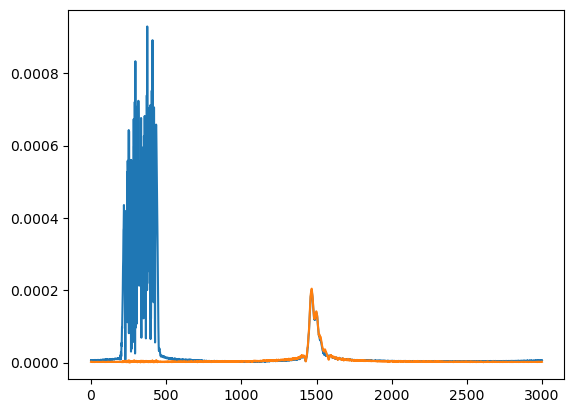

In [58]:
import pilottone as pt
plt.figure()
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_measured[pre_discard:,0,0])))
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_emicorr[pre_discard:,0,0])))

In [38]:
removeOS = True
Nsamp = ksp_emicorr.shape[0]
if removeOS:
    keepOS = np.concatenate([np.arange(Nsamp // 4), np.arange(Nsamp * 3 // 4, Nsamp)])
    ksp_emicorr = ifft(ksp_emicorr, axis=0)
    ksp_emicorr = fft(ksp_emicorr[keepOS, :, :], axis=0)
    Nsamp = Nsamp // 2